In [103]:
from dotenv import load_dotenv
load_dotenv()

from argparse import ArgumentParser
import warnings
from collections import OrderedDict
import json
import io
import os
import sys
import pickle
import base64
from traceback import print_exc

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data.sampler as sampler
from torchvision.transforms import Compose, Normalize, ToTensor
from tqdm import tqdm
from time import sleep, time

import matplotlib.pyplot as plt

import logging

from non_iid_generator.customDataset import CustomDataset

DEVICE = "cuda"

In [104]:
conf = json.loads(open("data/Cifar10_NIID_a05_140c/config.json", "r").read())
data = [dict(zip(np.array(cli)[:,0], np.array(cli)[:,1])) for cli in conf["Size of samples for labels in clients"]]

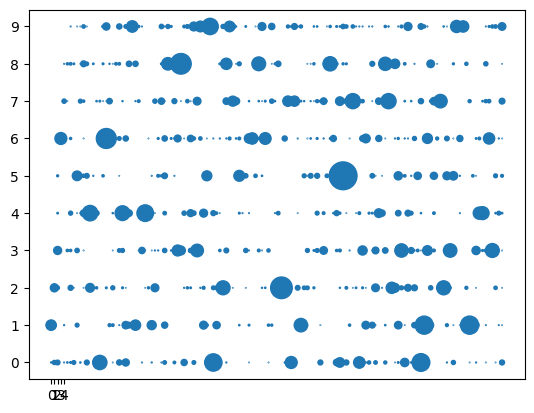

In [105]:
df = pd.DataFrame(data).replace(np.nan, 0)
x = np.array(np.meshgrid(np.arange(140),np.arange(10))).T.reshape(-1,2)[:,0]
y = np.array(np.meshgrid(np.arange(140),np.arange(10))).T.reshape(-1,2)[:,1]
s = df.values.reshape(1,-1)[0].astype("int")
s = (s - np.amin(s))/(np.amax(s) - np.amin(s))*400

plt.scatter(x,y,s)
plt.xticks(np.arange(5))
plt.yticks(np.arange(10))
plt.show()

In [106]:
main_label_vectors = np.zeros((140,10))

for client_id in range(140):
    for class_id in range(10):
        if class_id in data[client_id].keys():
            main_label_vectors[client_id][class_id] = data[client_id][class_id]

In [116]:
import math
from copy import deepcopy
import random

def dist(Z_i,Z_j):
    magnitude = lambda vector: math.sqrt(sum(pow(element, 2) for element in vector))
    Z_ij = Z_i+Z_j
    return magnitude(Z_ij/magnitude(Z_ij) - Z_global/magnitude(Z_global))


NO_CLIENTS = 140
N = 20
NO_ITER = 5
main_groups = np.zeros(NO_CLIENTS, dtype=int)

groups = deepcopy(main_groups)
label_vectors = deepcopy(main_label_vectors)

NO_GROUPS = NO_CLIENTS
for iterno in range(NO_ITER-1):
    print(f"ITER NO : {iterno}")

    Z_global = np.sum(label_vectors,axis=0)
    cnt = 1

    while 0 in groups:
        #select client
        client_k = None
        for i in range(len(label_vectors)):
            if groups[i] == 0:
                client_k = i
                break
        client_k = random.choice([i for i in range(len(label_vectors)) if groups[i] == 0])

        client_l = None
        while True:
            client_j = np.argmin([dist(label_vectors[client_k],label_vectors[j]) if(groups[j] == 0) else np.inf for j in range(NO_GROUPS)])
            client_l = np.argmin([dist(label_vectors[client_j],label_vectors[j]) if(groups[j] == 0) else np.inf for j in range(NO_GROUPS)])
            
            if client_l != client_k:
                client_k = client_l
                continue
            else: break
        
        # print(f"CNT : {cnt} | K : {client_k} | J : {client_j}")
        
        groups[client_k] = cnt
        groups[client_j] = cnt

        cnt += 1

    NO_GROUPS = len(np.unique(groups))
    print("NO GROUPS :", NO_GROUPS)
    new_label_vectors = np.zeros((NO_GROUPS,10))
    for idx, group_id in enumerate(np.unique(groups)):
        new_label_vectors[idx] = np.sum(label_vectors[groups == group_id], axis=0)

    label_vectors = new_label_vectors

    
    if iterno == 0:
        main_groups = deepcopy(groups)
    else:
        for idx in range(len(groups)):
            for main_idx in range(len(main_groups)):
                if main_groups[main_idx] == idx:
                    main_groups[main_idx] = groups[idx]
    
    groups = np.zeros(NO_GROUPS, dtype=int)

ITER NO : 0
NO GROUPS : 71
ITER NO : 1
NO GROUPS : 36
ITER NO : 2
NO GROUPS : 18
ITER NO : 3
NO GROUPS : 9


In [117]:
np.unique(main_groups, return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 18, 36, 71]),
 array([ 8, 14, 18, 12, 24,  8, 14, 15, 16,  8,  2,  1]))

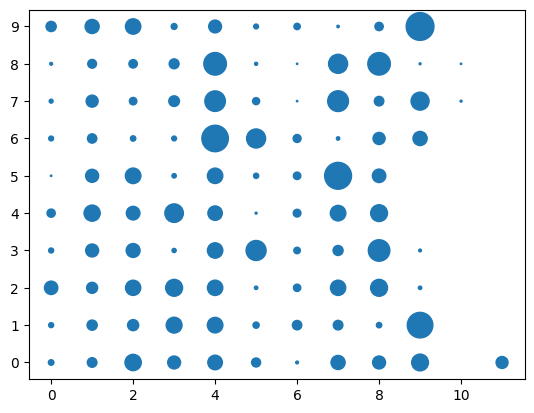

In [118]:
new_label_vectors = np.zeros((len(np.unique(main_groups)),10))

for idx, group_id in enumerate(np.unique(main_groups)):
    new_label_vectors[idx] = np.sum(main_label_vectors[main_groups == group_id], axis=0)

x = np.array(np.meshgrid(np.arange(len(np.unique(main_groups))),np.arange(10))).T.reshape(-1,2)[:,0]
y = np.array(np.meshgrid(np.arange(len(np.unique(main_groups))),np.arange(10))).T.reshape(-1,2)[:,1]
s = new_label_vectors.reshape(1,-1)[0]
s = ((s - np.amin(s))/(np.amax(s) - np.amin(s))*400).astype("int")

plt.scatter(x,y,s)
plt.yticks(np.arange(10))
plt.show()

In [97]:
new_label_vectors.shape

(14, 10)